# Scoring and Visualization

In [136]:
import glob
import os
import math
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import ipywidgets as widgets
import matplotlib.pyplot as plt

from keras.models import Model#, load_model
from keras import backend as K

from ipywidgets import interact, interact_manual
from IPython.display import Image
from mpl_toolkits import mplot3d
from tensorflow.keras.models import load_model


%matplotlib inline

pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000

In [137]:
input_n = 128

original_dir = '/datadrive/infused_innovations/images_filtered/'
label_dir = '/datadrive/infused_innovations/masks_filtered/'

original_cubes = glob.glob(os.path.join(original_dir, '*.npy'))
label_cubes = glob.glob(os.path.join(label_dir, '*.npy'))

In [10]:
print(len(original_cubes), len(label_cubes))

13214 13214


In [11]:
# load saved model
model = load_model('unet_best.h')

In [237]:
model2 = load_model('unet_best.h')

In [12]:
val_frame=pd.DataFrame(original_cubes)
val_frame['1']=label_cubes

In [13]:
val_frame

,0,1
0,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...
1,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...
2,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...
3,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...
4,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...
...,...,...
13209,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...
13210,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...
13211,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...
13212,/datadrive/infused_innovations/images_filtered...,/datadrive/infused_innovations/masks_filtered/...


In [115]:
def score_patch(img, model, threshold):
    dim = img.shape
    X = [img]
    X = np.array(X)/255.
    y_pred_proba = model.predict(X)
    y_pred = (y_pred_proba > threshold).astype(np.uint8)
    y_pred = y_pred[0].reshape(dim[0],dim[1])
    return y_pred

In [118]:
imgs = []
gt = []
preds = []

for i, row in val_frame.iterrows():
    if i < 10:
        cube_name, mask_name = row.values
        
        cube=np.load(cube_name)
        mask=np.load(mask_name).reshape(input_n, input_n)
        
        y_pred = score_patch(cube, model, 0.11)

        print(i, 'True count of 1s:', np.count_nonzero(mask), 'Predicted count of 1s:', np.count_nonzero(y_pred))
        gt.append(mask)
        preds.append(y_pred)
        imgs.append(cube)
        
    else:
        break

0 True count of 1s: 2005 Predicted count of 1s: 2593
1 True count of 1s: 101 Predicted count of 1s: 3899
2 True count of 1s: 0 Predicted count of 1s: 0
3 True count of 1s: 0 Predicted count of 1s: 0
4 True count of 1s: 0 Predicted count of 1s: 0
5 True count of 1s: 0 Predicted count of 1s: 0
6 True count of 1s: 2432 Predicted count of 1s: 2483
7 True count of 1s: 2432 Predicted count of 1s: 4892
8 True count of 1s: 788 Predicted count of 1s: 1129
9 True count of 1s: 0 Predicted count of 1s: 0


In [117]:
@interact

def visualize(i=(0,len(gt)-1)):
    
    #plot images 
    f, axarr = plt.subplots(1,3, figsize=(15,10), sharey=True)
    axarr[0].imshow(imgs[i])
    axarr[0].set_title('Image')   
    axarr[1].imshow(preds[i])
    axarr[1].set_title('Prediction')
    axarr[2].imshow(gt[i])
    axarr[2].set_title('Ground Truth')

interactive(children=(IntSlider(value=4, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

In [126]:
from dotenv import load_dotenv

In [138]:
load_dotenv()

im_dir = os.getenv('IMAGE_DIR')
mask_dir = os.getenv('MASK_DIR')

n = 128

In [153]:
"""
Slices image into patches of size NxNx3 according to stride
Zero pads any patches that are cut off at borders of image
Returns numpy array of image patches
"""

def slice_image(img, n, stride, channels):
    x_dim, y_dim = img.shape[0], img.shape[1]
    
    # calculate number of output cubes
    num_x = math.ceil((x_dim-n)/stride + 1)
    num_y = math.ceil((y_dim-n)/stride + 1)

    # iterate through img 
    results = np.zeros((num_x*num_y, n, n, channels), dtype=int)
    counter = 0

    for i in range(num_y):
        y = 0 if i==0 else y + stride
        for j in range(num_x):
            x = 0 if j==0 else x + stride

            cube = img[x:x+n, y:y+n]
            
            dims = cube.shape
            if channels == 1:
                cube = cube.reshape((dims[0],dims[1],1))
            results[counter,0:cube.shape[0],0:cube.shape[1]] = cube
            counter += 1
            
    size = (num_x, num_y)
    return results, size

In [218]:
def stitch_predictions(preds, size):
    stitched = np.zeros((size[0]*n,size[1]*n), dtype=int)

    x_i = 0
    x_j = n
    y_i = 0
    y_j = n
    for pred in preds:
        stitched[x_i:x_j, y_i:y_j] = pred

        if (x_j + n <= size[0]*n):
            x_i += n
            x_j += n
        else:
            x_i = 0
            x_j = n
            y_i += n
            y_j += n
            
    return stitched

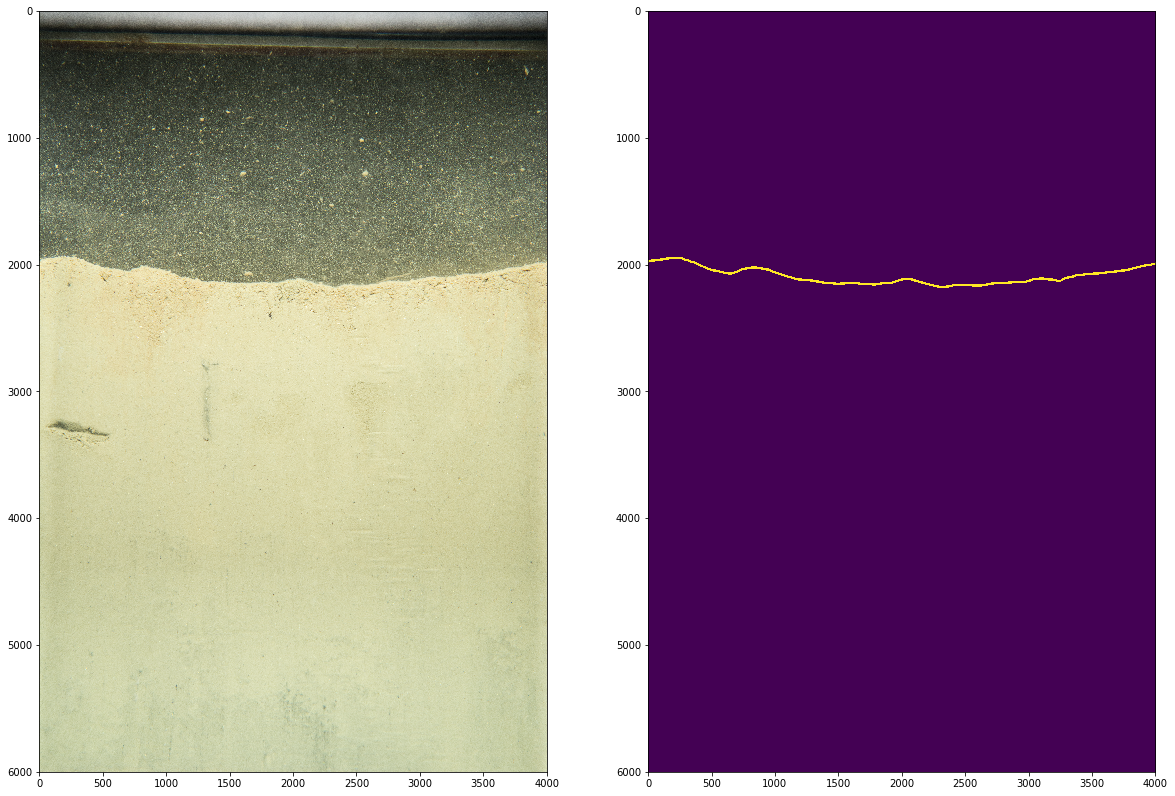

In [247]:
im_filenames = glob.glob(im_dir+'/*.npy', recursive=True)
mask_filenames = glob.glob(mask_dir+'/*.npy', recursive=True)

fig, axs = plt.subplots(1,2,figsize=(20,20))

im_filename = im_filenames[10]

im = np.load(im_filename)
filename = im_filename.split('/')[-1] #get image name
mask = np.load(os.path.join(mask_dir,filename))

axs[0].imshow(im)
axs[1].imshow(mask)

In [248]:
patches, size = slice_image(im, n, n, 3)

preds = []
for patch in patches:
    y_pred = score_patch(patch, model2, 0.1)
    preds.append(y_pred)

Text(0.5, 1.0, 'Ground Truth')

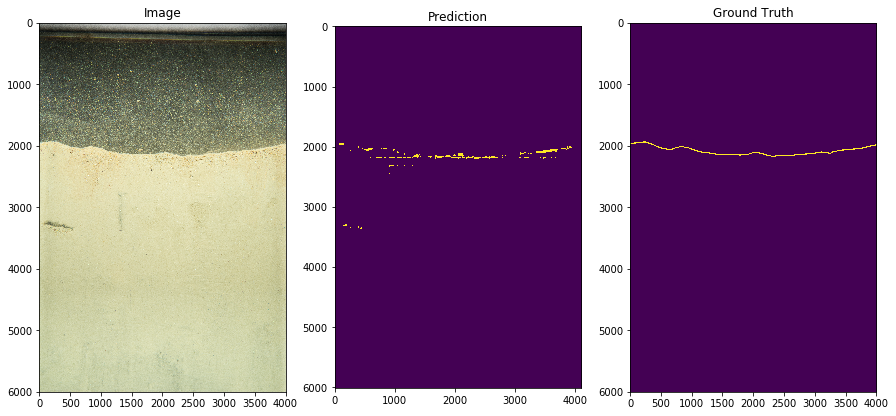

In [249]:
stitched = stitch_predictions(preds, size)

fig, axs = plt.subplots(1,3,figsize=(15,15))

axs[0].imshow(im)
axs[0].set_title('Image')   
axs[1].imshow(stitched)
axs[1].set_title('Prediction')   
axs[2].imshow(mask)
axs[2].set_title('Ground Truth')   